# 

# LangGraph Testing
I will be going through [this tutorial](https://langchain-ai.github.io/langgraph/tutorials/get-started/1-build-basic-chatbot/) to figure out how to build chatbots with LangGraph, and how that might be useful with PassionAI as well as learning it for internship work.

## Importing packages & loading env

In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from langchain_core.messages import ToolMessage

import os, json
from dotenv import load_dotenv

from IPython.display import Image, display

# load env
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_KEY")

## Setting up Basic LangGraph
- Setting up `StateGraph` which will be the workflow of the chatbot
- Setting `OPENAI_API_KEY` as an environment variable
- Initializing `GPT-4o` chat model with `init_chat_model`

In [2]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
llm = init_chat_model("openai:gpt-4o")

## Adding Nodes
- Adding a chatbot node to the `StateGraph`
    - `llm.invoke()` is the equivalent of making an API call to OpenAI (or the LLM of choice) and extracting the message content
    - `state["messages"]` is an instance of `State` we defined in the last code block
    - The `graph_builder` above has `StateGraph(State)`, which means the StateGraph can receive a `State` as input and output an update to that `State`
    - So, we return `"messages"` to update the `State`. The `add_messages` function when we defined `messages` as `Annotated` will append messages instead of overwriting
    - We then finally add this function and associate it with a node we name "chatbot"
- `START` defines the point where the chatbot will start per run
    - `add_edge` defines a directed edge, otherwise the nodes are just floating around
- We then compile from the graph builder

In [4]:
def chatbot(state: State):
    res = llm.invoke(state["messages"])
    return {"messages": [res]}

# add node with name "chatbot" and function chatbot
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot") # start node

# compile graph
graph = graph_builder.compile()

Displaying graph separately so we don't try to add nodes twice in the same kernel instance.

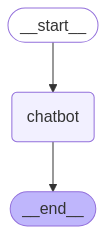

In [5]:
# display graph
display(Image(graph.get_graph().draw_mermaid_png()))

## Part 2: LangGraph w/ Tavily Search
- In this step we use `TavilySearch`, a package designed for searching for information an AI does not know
- We create a new node with function `chatbot_tools`
- We bind tools to the LLM (OpenAI in this case) with `llm.bind_tools(list of tools)`

In [3]:
from langchain_tavily import TavilySearch

os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
tool = TavilySearch(max_results=2)
tools = [tool]
# tool.invoke("What is Trump's tariff equation?")

def chatbot_tools(state: State):
    res = llm_with_tools.invoke(state["messages"])
    return {"messages": [res]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot_tools", chatbot_tools)
graph_builder.add_edge(START, "chatbot_tools")

# llm with tools
llm_with_tools = llm.bind_tools(tools)

## Defining a Tool Node
- We can use a prebuilt `ToolNode` but the following example shows what is going on underneath

In [ ]:
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

# create node and add it to our graph builder
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot_tools",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot_tools")
graph_builder.add_edge(START, "chatbot_tools")
graph = graph_builder.compile()

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

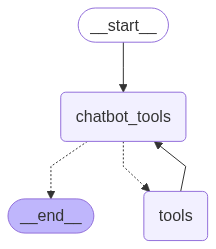

In [8]:
graph

## Run chatbot
- We run a loop that calls a `stream_graph_updates` function. It looks like we update the graph with user messages using `.stream()` and get the last message of the "messages" array

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break